# Implementing CNN in TensorFlow

Now, we will learn how to build CNN using Tensorflow. We will use MNIST handwritten digits dataset and understand how CNN recognize handwritten digits and we will also visualize how the convolutional layers extract important features from the image. 

## Import the libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')  

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST dataset

In [2]:
mnist = input_data.read_data_sets('data/mnist', one_hot=True) 

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


## Defining helper functions

Now,  we define the functions for initializing weights and bias and for performing convolution and pooling operation.

Initialize weights by drawing values from a truncated normal distribution with a standard deviation of 0.1. The weights are actually the filter. 

In [3]:
def initialize_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

Initialize the bias with constant value, 0.1:

In [4]:
def initialize_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

We define a function called convolution using tf.nn.conv2d() which actually performs the convolutional operation i.e element-wise multiplication of the input matrix (x) by the filter (w) with a stride of 1 and same padding. 

We set strides = [1,1,1,1]. The first and last values of strides are set to 1 which implies we don't want to move between training samples and different channels. The second and third values of strides are also set to 1 which implies we move the filter by 1 pixel in both height and width direction.

In [5]:
def convolution(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

We define a function called max_pooling using tf.nn.max_pool() to perform the pooling operation. We perform max pooling with strides of 2 and same padding, ksize implies our pooling window shape.

In [6]:
def max_pooling(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

### Define the placeholders for input and output

Placeholder for input image:

In [7]:
X_ = tf.placeholder(tf.float32, [None, 784])

Placeholder for reshaped input image:

In [8]:
X = tf.reshape(X_, [-1, 28, 28, 1])

Placeholder for output:

In [9]:
y = tf.placeholder(tf.float32, [None, 10])

## Define the Convolutional Network


Our network architecture consists of 2 convolutional layers. Each convolutional layer is followed by 1 pooling layer and we use a fully connected layer which is followed by an output layer.

That is, __convolution1->pooling1->convolution2->pooling2->fully connected layer-> output layer__


__First, we define the first convolutional layer and pooling layer:__

The weights are actually the filter in the convolutional layers. So, the weight matrix will be initialized as [ filter_shape[0], fliter_shape[1], number_of_input_channel, filter_size ]


We use a 5 x 5 filter. Since we use grayscale images, number of input channels will be 1 and we set the filter size as 32. 
 

So, the weight matrix of the first convolution layer will be [5,5,1,32].

In [10]:
W1 = initialize_weights([5,5,1,32])

Shape of the bias is just the filter size which is 32:

In [11]:
b1 = initialize_bias([32])

Perform the first convolution operation with ReLU activations followed by max pooling:

In [12]:
conv1 = tf.nn.relu(convolution(X, W1) + b1)
pool1 = max_pooling(conv1)


__Next, we define the Second convolutional and pooling layer:__

As the second convolutional layer takes the input from the first convolutional layer which has 32 channel output, the number of input channel to the second convolutional layer becomes 32 and we use 5 x 5 filter with a filter size of 64. Thus, the weight matrix for the second convolutional layer becomes [5,5,32,64].

In [13]:
W2 = initialize_weights([5,5,32,64])

Shape of the bias is just the filter size which is 64:

In [14]:
b2 = initialize_bias([64])

Perform the second convolution operation with ReLU activations followed by max pooling:

In [15]:
conv2 = tf.nn.relu(convolution(pool1, W2) + b2)
pool2 = max_pooling(conv2)

After two convolution and pooling layers, we need to flatten the output before feeding it to the fully connected layer. So, we flatten the result of the second pooling layer and feed it to the fully connected layer.



__Flatten the result of the second pooling layer:__

In [16]:
flattened = tf.reshape(pool2, [-1, 7*7*64])

__Define the Fully connected layer:__

Now we define the weights and bias for the fully connected layer. We know that we set the shape of the weight matrix as [number of neurons in the current layer, number of neurons layer in the next layer].

Since the shape of the input image becomes 7x7x64 after flattening and we use 1024 neurons in the hidden layer. The shape of the weights become [7x7x64, 1024].

In [17]:
W_fc = initialize_weights([7*7*64, 1024])
b_fc = initialize_bias([1024])

Fully connected layer with ReLU activations:

In [18]:
fc_output = tf.nn.relu(tf.matmul(flattened, W_fc) + b_fc)

__Define the output Layer__:

We have 1024 neurons in the current layer and since we need to predict 10 classes we have 10 neurons in the next layer, thus shape of the weight matrix becomes [1024 x 10]

In [19]:
W_out = initialize_weights([1024, 10])
b_out = initialize_bias([10])

Compute output with softmax activations:

In [20]:
y_hat = tf.nn.softmax(tf.matmul(fc_output, W_out) + b_out)

## Compute Loss

Compute the loss using cross entropy. We know that cross entropy loss is given as:

$$ \operatorname{cross entropy} =  - \sum_i y log (\hat{y}_i) $$


where $y$ is the actual label and $\hat{y}$ is the predicted label. 

Thus, cross entropy loss is implemented as:



In [21]:
cross_entropy = -tf.reduce_sum(y*tf.log(y_hat))

Minimize the loss using Adam optimizer with 1e-4 as learning rate:

In [22]:
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

Compute accuracy:

In [23]:
predicted_digit = tf.argmax(y_hat, 1)
actual_digit = tf.argmax(y, 1)

correct_pred = tf.equal(predicted_digit,actual_digit)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Start training the CNN 

Start the tensorflow session and initialize all variables,

In [24]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Train the model for 1000 epoch. Print the results for every 100 epochs,

In [25]:
for epoch in range(1000):
    
    #select some batch of data points according to the batch size (100)
    X_batch, y_batch = mnist.train.next_batch(batch_size=100)
    
    #train the network
    loss, acc,  _ = sess.run([cross_entropy, accuracy, optimizer], feed_dict={X_: X_batch, y: y_batch})
    
    #print the loss on every 100th epoch
    if epoch%100 == 0:
        print('Epoch: {}, Loss:{} Accuracy: {}'.format(epoch,loss,acc))

Epoch: 0, Loss:637.368591309 Accuracy: 0.15000000596
Epoch: 100, Loss:46.8891830444 Accuracy: 0.910000026226
Epoch: 200, Loss:46.2926445007 Accuracy: 0.879999995232
Epoch: 300, Loss:10.5865783691 Accuracy: 0.959999978542
Epoch: 400, Loss:15.8229551315 Accuracy: 0.949999988079
Epoch: 500, Loss:15.4611291885 Accuracy: 0.939999997616
Epoch: 600, Loss:13.0949325562 Accuracy: 0.949999988079
Epoch: 700, Loss:5.35812568665 Accuracy: 0.990000009537
Epoch: 800, Loss:9.73382663727 Accuracy: 0.990000009537
Epoch: 900, Loss:6.86854743958 Accuracy: 0.959999978542


As you can see above, the loss is getting decreased and accuracy is getting increased over the epochs. 

## Visualizing extracted features


Now that we have trained our CNN model, we see what features our CNN has extracted to recognize the image. As we learned that each convolutional layer extracts important features from the image. We will see what features our first convolutional layer has extracted to recognize the handwritten digits. 

First, let us select one image from the training set say digit 2,

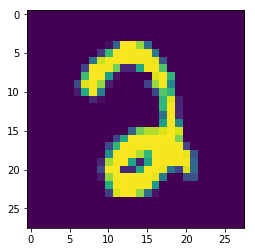

In [26]:
plt.imshow(mnist.train.images[5].reshape([28, 28]))

Feed this image to the first convolutional layer, that is, conv1 and get the feature maps:

In [27]:
image = mnist.train.images[7].reshape([-1, 784])
feature_map = sess.run([conv1], feed_dict={X_: image})[0]

Plot the feature map. As you can see in the below plot, the first convolutional layer has learned to extract edges from the given image

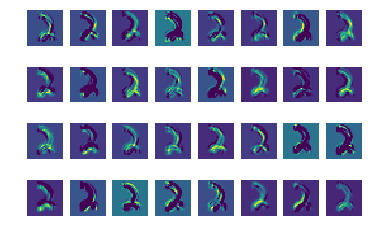

In [28]:
for i in range(32):
    feature = feature_map[:,:,:,i].reshape([28, 28])
    plt.subplot(4,8, i + 1)
    plt.imshow(feature)
    plt.axis('off')
plt.show()

Thus, this is how the convolutional neural network uses multiple convolutional layers to extract important features from the image and feed these extracted features to a fully connected layer to classify the image. 


Now that we have learned how CNN works in the next section we will learn several interesting architectures of CNN.